In [13]:
import torch 
import matplotlib.pyplot as plt; plt.rcParams["figure.dpi"] = 500
import numpy as np
import h5py
import sys 
models_folder = "..\\Models architecture"
sys.path.append(models_folder)

In [14]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

## Importing the model and loading the trained weights

In [15]:
weights_path =  '..\\Data\\cosmic_survey\\z32_beta0.1_weightscvae2.pt'
weights, hyperparameters = torch.load(weights_path)

z_dim = hyperparameters["z_dim"]
batchsize = hyperparameters["batch size"]


In [16]:
# Try to change the model for cvae or fancy_cvae (need to have nc = 2 then)
from cvae2 import VariationalAutoencoder
vae = VariationalAutoencoder(z_dim).to(device)
vae.load_state_dict(weights)

<All keys matched successfully>

## Importing data 

In [17]:
class Hdf_dataset(torch.utils.data.Dataset):
    def __init__(self, file):
        self.file = file
        self.hdf = h5py.File(file, 'r')
        self.datasets = list(self.hdf.keys())

    def __len__(self):
        return len(self.hdf[self.datasets[0]])
    
    def __getitem__(self,idx):
        # Cosmic survey dataset: galaxy images and redshifts
        if len(self.datasets) == 2:
            x = self.hdf[self.datasets[0]][idx]
            z = self.hdf[self.datasets[1]][idx]
            return x, z
        
        # Deepfield dataset: just galaxy images
        else:
            x = self.hdf[self.datasets[0]][idx]
            return x

In [18]:
data_cosmic_survey = '...\\cosmos_25.2_all_with_zphot.h5'
data_deepfield = '...\\cosmos_23.5_128_augmented_denoised.h5'
galaxy_dataset = Hdf_dataset(data_cosmic_survey)

# Visualizing the latent space
To visualize the latent space of the trained model, I'll use 2d histograms:  
- First, we'll encode each image of the dataset into its latent tensor of dimension $z_{dim}$.  
- Then, we want to separate each dimension of the encoded dataset to create a tensor $z_i$ containing the -ith dimension of the latent tensors.  
- Finally, we just plot the `hist2d(z_i, z_j)` with $i\neq j$

In [19]:
# Changes needed in the loop if you want to visualize the latent space of the vaes, the cvae and fancy_cvae models (Helper file needed)
z_complete_dataset = torch.empty(size = (len(galaxy_dataset), z_dim))

with torch.no_grad(): # No need to track the gradients > no crash due to a lack of RAM 
     for i, x in enumerate(galaxy_dataset):
          galaxy_image = torch.from_numpy(x[0]).unsqueeze(0).to(device)
          condition = torch.tensor([x[1]]).to(device)
          
          z_cat = vae.encoder(galaxy_image, condition) # output of the encoder is the concatenated latent tensor (N, z_dim + 1)
          z_complete_dataset[i] = z_cat.squeeze()[:-1]

In [20]:
for i in range(z_dim): 
    var = "z" + f"{i}"
    locals()[var] = z_complete_dataset[:,i]

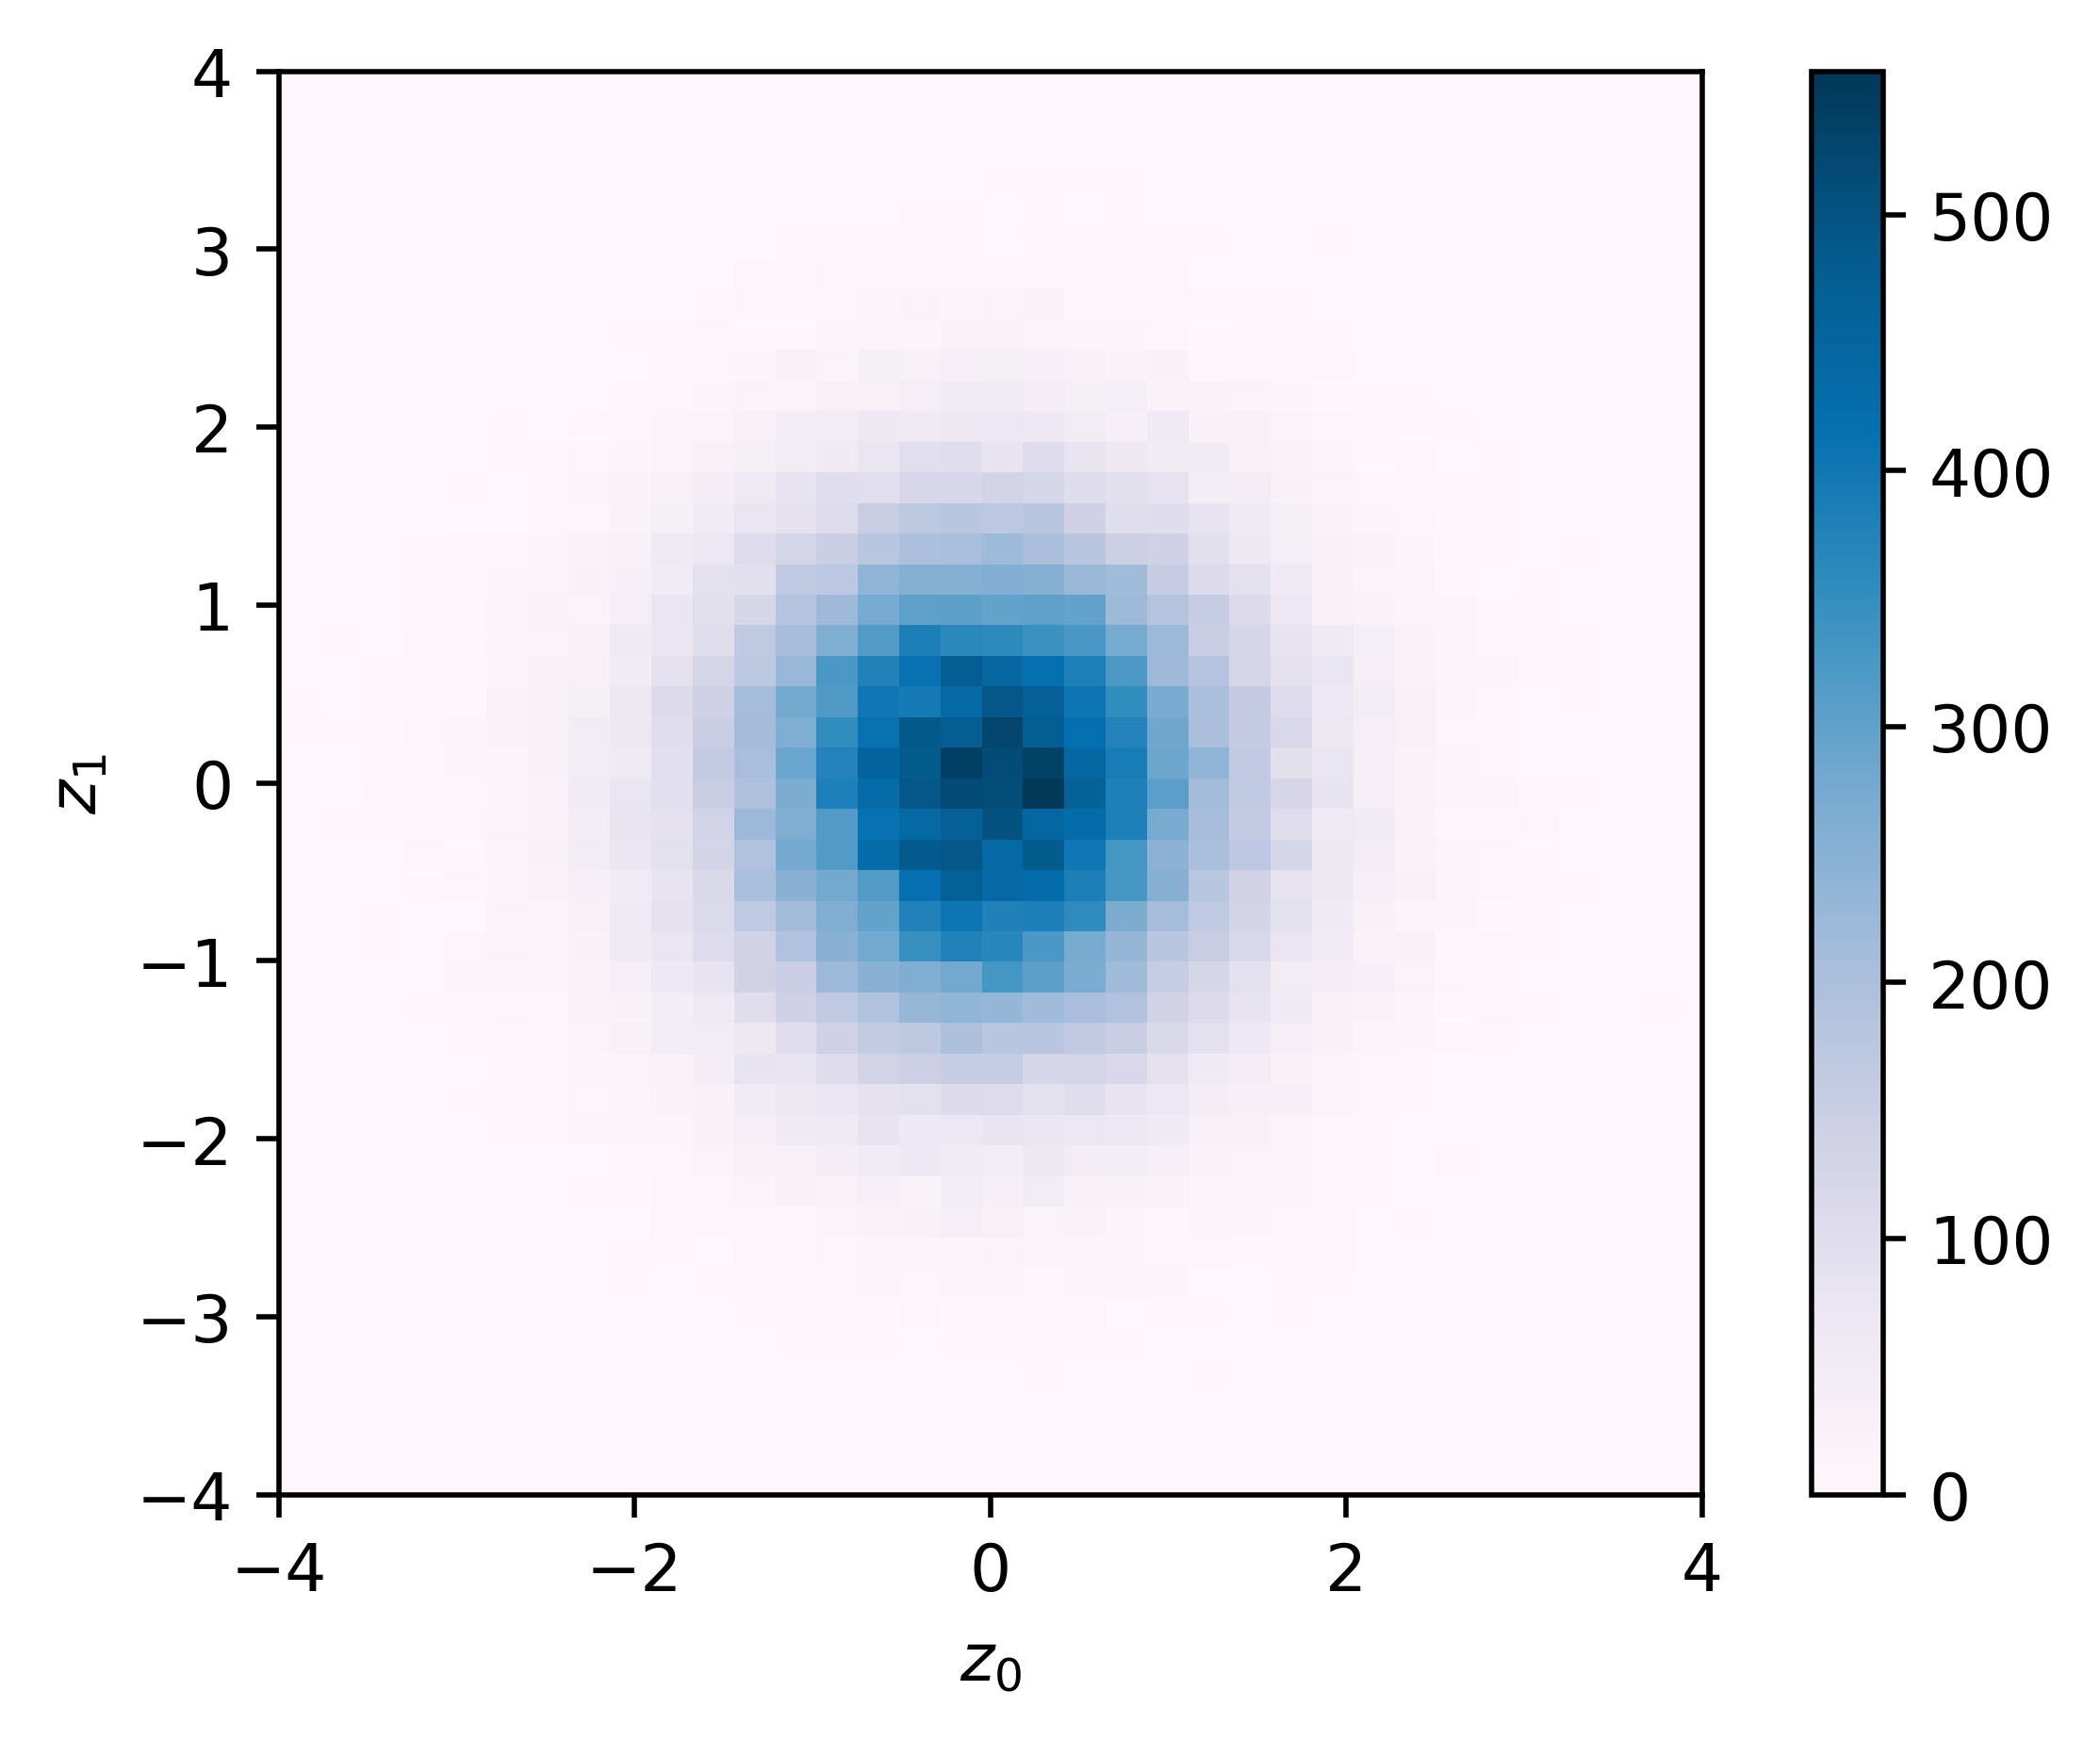

In [24]:
plt.hist2d(z0.numpy(), z4.numpy(), bins = 50, cmap = 'PuBu')
plt.xlabel(r"$z_0$")
plt.ylabel(r"$z_1$")
plt.gca().set_aspect("equal")
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.colorbar()
